# Replication of Blanchard and Quah AER 1989
**The Dynamic Effects of Aggregate Demand and Supply Disturbances Olivier Jean Blanchard and Danny Quah. The American Economic Review , Vol. 79, No. 4 (Sep., 1989), pp. 655-673**

Francesco Franco, NOVA SBE
Empirical Macroeconomics


In [1]:
'''Importing packages and functions''' 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
'''Downloading and preparing data using DataReader'''

from pandas_datareader.data import DataReader            
#Sample selection
start = '1948Q1'                                              
end   = '1987Q3'

#Data from FRED
gdp   = DataReader('GNPC96', 'fred', start=start,  end=end) # quarterly frequency
urate = DataReader('UNRATE', 'fred', start=start, end=end)  # monthly frequency

In [3]:
'''Transforming the data part 1'''

#Frequency change for urate
urateq = urate.resample('Q').mean() # Convenience method for frequency conversion and resampling of time series. 
                                    # Object must have a datetime-like index 
#urateq = urate.groupby(pd.PeriodIndex(urate.index, freq='Q'), axis=0).mean()

#From YYYYQ format to date format (find it important for matplotlib)
gdp.index    = pd.date_range(start,'1987Q4',freq="Q")
urateq.index = pd.date_range(start,'1987Q4',freq="Q")

#create Frame
df          = pd.concat((urateq, gdp), axis=1)
df.columns  = ["urate","gdp"]
df["lngdp"] = np.log(df["gdp"])
df["dy"]    = (df["lngdp"] - df["lngdp"].shift(1))*400 #annualized quarterly GDP growth
df          = df[1:] # drop first observation

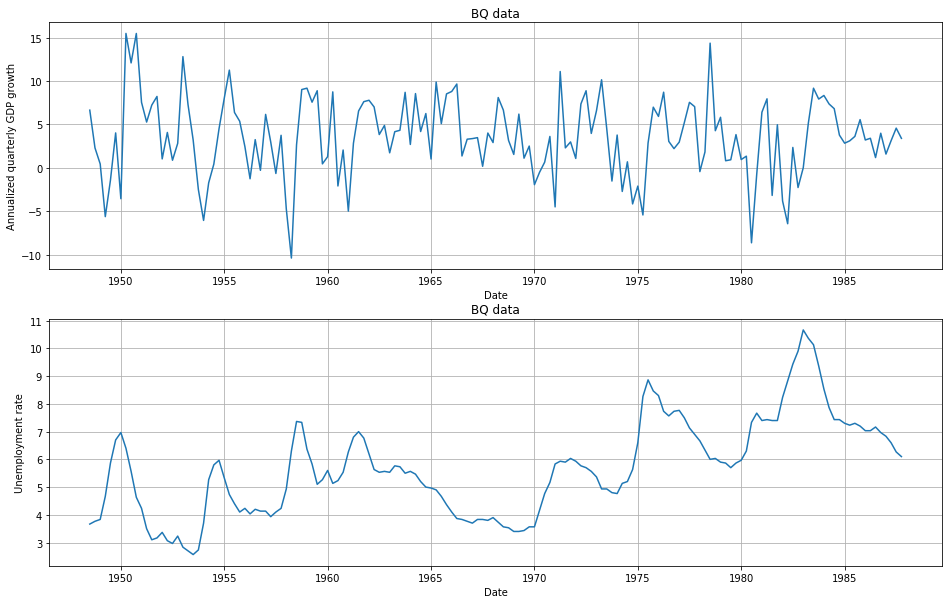

In [4]:
# Plot data
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(16,10))

plt.subplot(211)
plt.plot(df["dy"])
plt.xlabel('Date')
plt.ylabel('Annualized quarterly GDP growth')
plt.title('BQ data')
plt.grid()

plt.subplot(212)
plt.plot(df["urate"])
plt.xlabel('Date')
plt.ylabel('Unemployment rate')
plt.title('BQ data')
plt.grid()

plt.show()


In [5]:
'''Transforming the data part 2'''
from scipy import signal
# Detrending as in the paper: Important to make the data covariance stationary
# Productivity Slowdown less apparent than in origal data, upward trend in urate present

df.loc[:"1973Q2","dys"] = signal.detrend(df.loc[:"1973Q2","dy"],type="constant")
df.loc["1973Q3":,"dys"] = signal.detrend(df.loc["1973Q3":,"dy"],type="constant")
df["urates"]            = signal.detrend(df["urate"])

In [6]:
#?signal.detrend

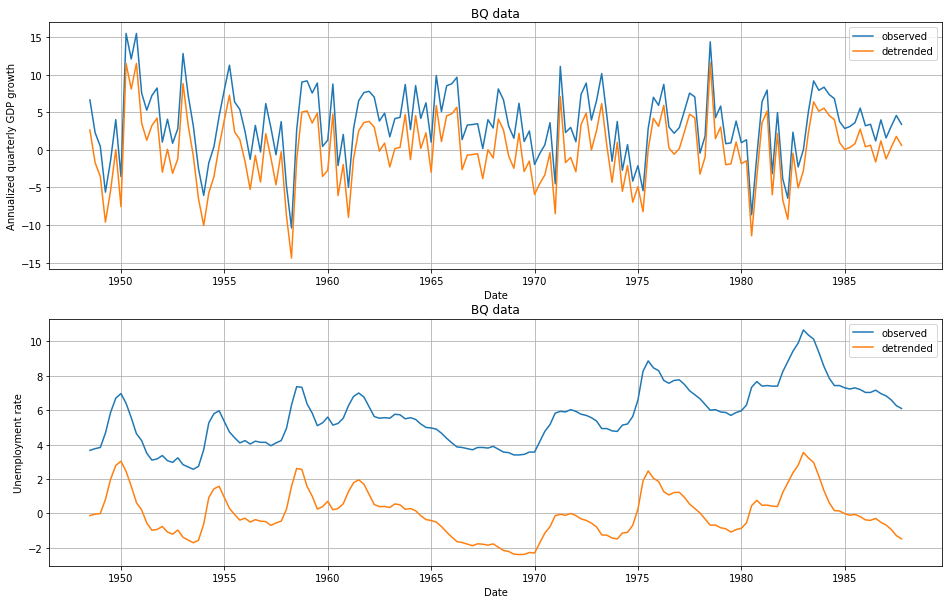

In [7]:
# Plot original data & detrended data

plt.figure(figsize=(16,10))

plt.subplot(211)
plt.plot(df['dy'],label='observed')
plt.plot(df['dys'],label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Annualized quarterly GDP growth')
plt.title('BQ data')
plt.grid()

plt.subplot(212)
plt.plot(df['urate'],label='observed')
plt.plot(df['urates'],label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Unemployment rate')
plt.title('BQ data')
plt.grid()

plt.show()

In [8]:
'''Estimation part 1'''
#Setting up the data for VAR

X = df.loc[:,["dys","urates"]].copy()

## Reduced form VAR code
$$x_t=\hat{B}(1)X_{t-1} + \hat{B}(2)x_{t-2} + ... + \epsilon_t$$

where $x_t$ is $n\times 1$ matrix of data.andwhere $\hat{B}(i)$ is a $n\times n$ matrix of coefficients.
Note that we do not put a constant since the variabes are detrended 
(so have mean 0 over the sample period)


In [9]:
# If we were lazy....
# we could use the statistical package statsmodel

import statsmodels.api as sm
from statsmodels.tsa.api import VAR

# this creates a model VAR which has a lot of methos availabe for example fit
model   = VAR(X)
results = model.fit(8,trend='nc')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 03, Apr, 2019
Time:                     23:04:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.511799
Nobs:                     150.000    HQIC:                  0.130464
Log likelihood:          -383.896    FPE:                   0.879115
AIC:                    -0.130469    Det(Omega_mle):        0.717814
--------------------------------------------------------------------
Results for equation dys
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
L1.dys            0.062713         0.114362            0.548           0.583
L1.urates        -3.625091         1.420617           -2.552           0.011
L2.dys            0.098538         0.118476            0.832           0.406
L

We must run battery of tests to be sure your specifiaction is correct
$$FPE=\left|\Omega\right|\left(\frac{T+Kp+1}{T+Kp-1}\right)^{K}$$
$$AIC=-2\left(\frac{\mathcal{L}}{T}\right)+2\frac{t_{p}}{T}$$
$$SBIC=-2\left(\frac{\mathcal{L}}{T}\right)+2\frac{ln(T)}{T}t_{p}$$
$$HQIC=-2\left(\frac{\mathcal{L}}{T}\right)+\frac{2ln(ln(T))}{T}t_{p}$$

Notice that statsmodels produce different values of the above statistics

In [10]:
# Lag selection in statsmodels
model.select_order(8,trend='nc').summary()

,AIC,BIC,FPE,HQIC
0,-0.07471,0.005578,0.9280,-0.04209
1,-0.2204,-0.05981,0.8022,-0.1551
2,-0.2540,-0.01319*,0.7757,-0.1562
3,-0.2268*,0.09430,0.7972*,-0.09637*
4,-0.1953,0.2062,0.8229,-0.03218
5,-0.2090,0.2727,0.8119,-0.01332
6,-0.1644,0.3976,0.8493,0.06388
7,-0.1305,0.5118,0.8791,0.1305


In [11]:
# The formulas are different as they use the fact that loglikehood is related to determinant

AIC  = -2*(results.llf/150) +2*32/150
AIC2 = AIC -2*np.log(2*np.pi)-2  # relation with statsmodel formula
print(AIC2)

-0.13046939026097792


But we are not lazy...(in reality we need to learn).
We can write the model in a bigger one and use OLS which is equivalent to Maximum Likelihood for an unsrestricted VAR
$$X = X_L\hat{B} + EPS$$
where $X$ is $T\times n$,$X_L$ is $T\times (n\times p)$ and $\hat{B}$ is $(n\times p) \times n$

$\hat{B}$ = $[\hat{B}(1)...\hat{B}(p)]$

- You can also find it as $$X'=\hat{B}'(X_L)'+EPS'$$


In [12]:
from numpy.linalg import inv

#let us construct the matrix of lags

XLAG     = pd.DataFrame()
num_lags = 8 
for i in range(1,num_lags+1):
    XLAG = pd.concat([XLAG,X.shift(i).add_suffix("-"+str(i))],axis=1)

#change names to frames that we modify    
X2       = X.iloc[num_lags:,:]
XLAG2    = XLAG.iloc[num_lags:,:]
num_vars = X2.shape[1]
num_obs  = XLAG2.shape[0]

#Building arrays for using OLS
X3       = np.array(X2)
XLAG3    = np.array(XLAG2)

#VAR - standard OLS
Bhat     = inv(XLAG3.T@XLAG3)@XLAG3.T@X3

Now let us apply our identification restrictions to the covariance matrix of the estimated innovations $v=A(0)\epsilon$
1. $\epsilon\epsilon'=I$ therefore $\Omega=A(0)A(0)'$, gives us three restrictions
2. $LR_{11}=0$ where $LR=(I+C(1)+C(2)+...)A(0)=(I-C)^{-1}A(0)$, gives us one restriction.
below let us denote $(I-C)^{-1}$ as Mhat

In [14]:
#Estimated errors
EPS = (X3 - XLAG3@Bhat)

#estimated covariance matrix
Omegahat = EPS.T@EPS/(num_obs - num_lags*num_vars)

# Putting problem in canonical form (VAR(8) into VAR(1))
# c_x(t) = c_Bhat*c_x(t-1) + c_G*eta(t)
# c_Bhat = [ Bhat' ; eye((n_lags-1)*n_vars) zeros((n_lags-1)*n_vars,n_vars) ] ;

c_Bhat = np.vstack((Bhat.T,np.hstack((np.identity((num_lags-1)*num_vars),np.zeros([(num_lags-1)*num_vars,num_vars]))))) 

#Setting up for LR restriction
c_Mhat = inv(np.identity(c_Bhat.shape[0])-c_Bhat)
Mhat   = c_Mhat[:2,:2]

In [15]:
def objective(x0,Mhat,Omegahat,num_vars): 
    
        '''objective function to impose restrictions on the variance covariance matrix
           of the estimated reduced form, starts with x0, outputs H,
            which it uses again as x0 until convergence'''
    
        A0   = np.reshape(x0,[num_vars,num_vars]) #grab starting values, and create a possible matrix  A(0)
        LR  = Mhat@A0                             #LR effect given by multiplication of Mhat and A0
        H   = A0@A0.T - Omegahat                  #A(0)*A(0).T should be equal to Omegahat, 
                                                  #as variance of shocks is identity
        H[0,1] = LR[0,1]                          #We add LR restriction
        H = H.flatten()
        return H #each parameter in H must be equal to 0, including LR restriction

In [16]:
'''solve the system of equation to find the structural parameters'''
from scipy.optimize import root

x0 = ((Omegahat**2)**.25).flatten() #Starting values, flatten is needed for root function below
#returns the values of G, A(0), which guarantee LR restriction = 0,
#as well as the information from variance-covariance matrix
sol = root(objective,x0,args=(Mhat,Omegahat,num_vars)) # Solves F(X) = 0, where both X and 0 can be vectors
A0   = sol.x.reshape([num_vars,num_vars]) 
 

#the first shock (supply) should have a positive impact on output (only redefines direction, and changes nothing)
if A0[0,0] < 0: A0[:,0] = -A0[:,0]

#the second shock (demand) should have a positive impact on output (only redefines direction, and changes nothing)
if A0[0,1] < 0: A0[:,1] = -A0[:,1]

#Estimating structural shocks, ETA
F   = inv(A0)
ETA = EPS@F.T

We can now compute the IRF
$$\hat{X}_{t+s}=\sum_{i=0}^{s-1}C_{i}A(0)\epsilon_{t+s-i}$$
define $$\Psi_{i}=\left[\left(C\right)^{i}A(0)\right]$$
you want to study $$\frac{\partial\hat{X}_{t+s}}{\partial\epsilon_{t}}=\Psi_{s}$$

In [17]:
# number of periods for IRFS and VARDEC
num_impulses = 40

In [18]:
#IRFs
'''IRFs are stored in a 3-dimensional array. Dimension 1 is time. Dimension
    2 is variable, and 3 is shock. So IRF(:,2,1) gives the impulse response
    of the second variable to the first shock. IRF_sum gives the integrated
    responses (i.e, in levels). IRF_sum(:,1,1) gives the cumulative impulse
    response of variable 1 to shock 1.'''
    
IRF  = np.zeros([num_impulses,num_vars,num_vars])
Temp = np.identity(c_Bhat.shape[0])

psi  = []
for t in range(num_impulses):
    psi_t = Temp[:num_vars,:num_vars] 
    IRF[t,:,:] = psi_t@A0 # store the IRF
    Temp = c_Bhat@Temp   # computes the exponent of the matrix
    #psi.append(psi_t)            # stores the matrices Psi (notations as in Hamilton)

irf  = pd.DataFrame({i:IRF[i].flatten() for i in range(num_impulses)}).T #save IRFs into dataframe
irf.columns = ["s_y","d_y","s_u","d_u"]
irf_cum = irf.cumsum() #output is expressed cumulatively

irf_final = pd.concat([irf_cum["s_y"], #supply shock on output
                       irf_cum["d_y"], #demand shock on output
                       irf["s_u"], #supply shock on unemployment
                       irf["d_u"]],axis=1) #demand shock on unemployment

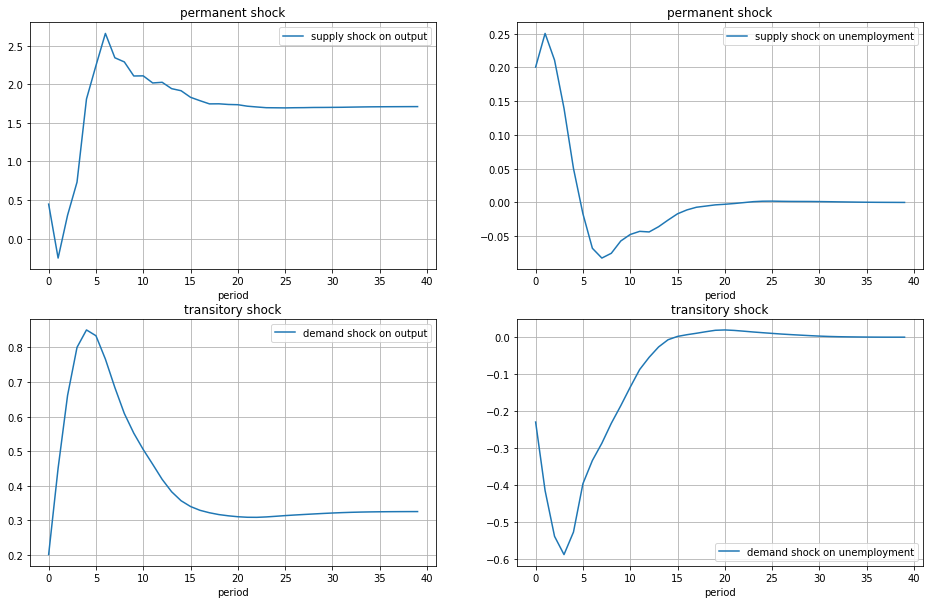

In [19]:
# Plot the IRFs

plt.figure(figsize=(16,10))

plt.subplot(221)
plt.plot(irf_cum["s_y"],label='supply shock on output')
plt.legend()
plt.xlabel('period')
plt.title('permanent shock')
plt.grid()

plt.subplot(222)
plt.plot(irf["s_u"],label='supply shock on unemployment')
plt.legend()
plt.xlabel('period')
plt.title('permanent shock')
plt.grid()

plt.subplot(223)
plt.plot(irf_cum["s_u"],label='demand shock on output')
plt.legend()
plt.xlabel('period')
plt.title('transitory shock')
plt.grid()

plt.subplot(224)
plt.plot(irf["d_u"],label='demand shock on unemployment')
plt.legend()
plt.xlabel('period')
plt.title('transitory shock')
plt.grid()

plt.show()

Variance decomposition
$$FEV^{D}=E_{t_{0}}\left[\left(X_{t_{0}+s}-\widehat{X}_{t_{0}+s}\right)\left(X_{t_{0}+s}-\widehat{X}_{t_{0}+s}\right)^{\prime}\right]=\sum_{t=0}^{s-1}C_{t}\Omega C_{t}^{\prime}$$
$$\Omega=AA^{\prime}=\sum_{j=1}^{n_{vars}}a_{j}a_{j}^{\prime}$$

In [20]:
'''Vfrac_D(:,1,1) : variance of the first variable explained by varshock
   Vfrac_D(:,2,2) : variance of the second variable explained by varshock
   Vfrac_L : same for levels (cumulative response)'''

MSE1_D = np.zeros([num_impulses,num_vars,num_vars]) 
MSE2_D = np.zeros([num_impulses,num_vars,num_vars]) 
MSE1_t = np.zeros([num_vars,num_vars]) 
MSE2_t = np.zeros([num_vars,num_vars]) 
g1 = A0[:,:1] 
g2 = A0[:,1:2] 
Temp = np.identity(c_Bhat.shape[0])               # for i=1, Temp is Identity.
for t in range(num_impulses): 
    Psi_t = Temp[:num_vars,:num_vars]    # extracts the upper left block.
    
    MSE1_t = MSE1_t + np.dot(np.dot(Psi_t,g1),np.dot(g1.T,Psi_t.T))                        
    MSE2_t = MSE2_t + np.dot(np.dot(Psi_t,g2),np.dot(g2.T,Psi_t.T))
    MSE1_D[t,:,:] = MSE1_t 
    MSE2_D[t,:,:] = MSE2_t 
    Temp = np.dot(c_Bhat,Temp)

Vfrac_D1 = MSE1_D/(MSE1_D+MSE2_D)
Vfrac_D2 = MSE2_D/(MSE1_D+MSE2_D)


In [21]:
vfrac_D1 = pd.DataFrame({i:Vfrac_D1[i].flatten() for i in range(num_impulses)}).T #save Vardec into dataframe
vfrac_D1.columns = ["vs_dy","","","vs_u"]
vfrac_D1_final   = pd.concat([vfrac_D1["vs_dy"],        #supply shock on variance of growth of output
                              vfrac_D1["vs_u"]],axis=1) #supply shock on variance of unemployment

In [22]:
vfrac_D2 = pd.DataFrame({i:Vfrac_D2[i].flatten() for i in range(num_impulses)}).T #save Vardec into dataframe
vfrac_D2.columns = ["vd_dy","","","vd_u"]
vfrac_D2_final   = pd.concat([vfrac_D2["vd_dy"],     #demand shock on variance of growth of output
                           vfrac_D2["vd_u"]],axis=1) #demand shock on variance of unemployment
vfrac_final      = pd.concat([vfrac_D1["vs_dy"], vfrac_D1["vs_u"],
                              vfrac_D2["vd_dy"],vfrac_D2["vd_u"]],axis=1)

In [23]:
'''Vfrac_D(:,1,1) : variance of the first variable explained by varshock
   Vfrac_D(:,2,2) : variance of the second variable explained by varshock
   Vfrac_L : same for levels (cumulative response)'''

MSE1_L = np.zeros([num_impulses,num_vars,num_vars]) 
MSE2_L = np.zeros([num_impulses,num_vars,num_vars]) 
MSE1_t = np.zeros([num_vars,num_vars]) 
MSE2_t = np.zeros([num_vars,num_vars]) 
g1 = A0[:,:1] 
g2 = A0[:,1:2] 
Temp = np.identity(c_Bhat.shape[0])      # for i=1, Temp is Identity.
for t in range(num_impulses): 
    Psi_t = Temp[:num_vars,:num_vars]    # extracts the upper left block.
    
    MSE1_t = MSE1_t + np.dot(np.dot(Psi_t,g1),np.dot(g1.T,Psi_t.T))                        
    MSE2_t = MSE2_t + np.dot(np.dot(Psi_t,g2),np.dot(g2.T,Psi_t.T))
    MSE1_L[t,:,:] = MSE1_t 
    MSE2_L[t,:,:] = MSE2_t 
    Temp = np.identity(c_Bhat.shape[0]) + np.dot(c_Bhat,Temp)

Vfrac_L1 = MSE1_L/(MSE1_L+MSE2_L)
Vfrac_L2 =MSE2_L/(MSE1_L+MSE2_L)


In [24]:
vfrac_L1 = pd.DataFrame({i:Vfrac_L1[i].flatten() for i in range(num_impulses)}).T #save vardec into dataframe
vfrac_L1.columns = ["vs_y","","",""]
vfrac_L1_final = vfrac_L1["vs_y"] #supply shock on variance of output
                         
vfrac_L2 = pd.DataFrame({i:Vfrac_L2[i].flatten() for i in range(num_impulses)}).T #save IRFs into dataframe
vfrac_L2.columns = ["vd_y","","",""]
vfrac_L2_final = vfrac_L2["vd_y"] #demand shock on on variance of output
                          
vfrac_final_L=pd.concat([vfrac_L1["vs_y"],vfrac_L2["vd_y"]],axis=1)

In [25]:
A0_hat = np.vstack((A0,np.zeros([(num_lags-1)*num_vars,num_vars])))

In [26]:
# simulation
#shut down a shock
ETA_D = ETA.copy()
ETA_D[:,0]=np.zeros((num_obs))
ETA_S = ETA.copy()
ETA_S[:,1]=np.zeros((num_obs))
X_sim = np.zeros([num_vars,num_lags])

for i in range(num_lags):
    X_sim[:,num_lags-1-i]=X.iloc[i,:]
    
X_sim   = np.reshape(X_sim,(num_lags*num_vars,1),order='F')
X_sim   = np.hstack((X_sim,np.zeros([num_lags*num_vars,num_obs-1])))
X_sim_D = X_sim.copy()
X_sim_S = X_sim.copy()

for t in range(num_obs-num_lags):
    X_sim[:,t+1]   = np.dot(c_Bhat,X_sim[:,t])   + np.dot(A0_hat,ETA.T[:,t])
    X_sim_D[:,t+1] = np.dot(c_Bhat,X_sim_D[:,t]) + np.dot(A0_hat,ETA_D.T[:,t])
    X_sim_S[:,t+1] = np.dot(c_Bhat,X_sim_S[:,t]) + np.dot(A0_hat,ETA_S.T[:,t])


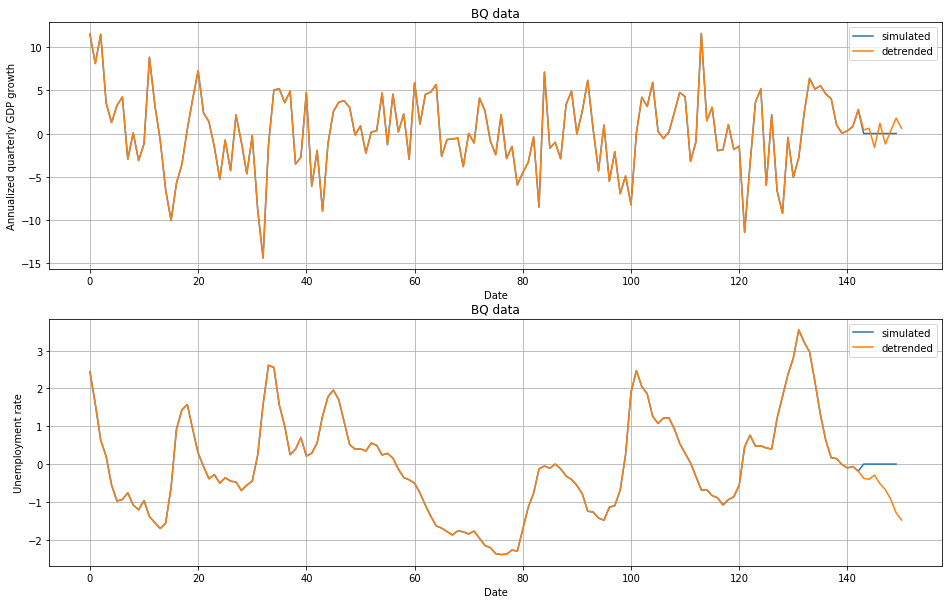

In [27]:
# Plot original data & simulated data
plt.figure(figsize=(16,10))

plt.subplot(211)
plt.plot(X_sim[0,:],label='simulated')
plt.plot(np.array(df['dys'][7:]),label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Annualized quarterly GDP growth')
plt.title('BQ data')
plt.grid()

plt.subplot(212)
plt.plot(X_sim[1,:],label='simulated')
plt.plot(np.array(df['urates'][7:]),label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Unemployment rate')
plt.title('BQ data')
plt.grid()

plt.show()


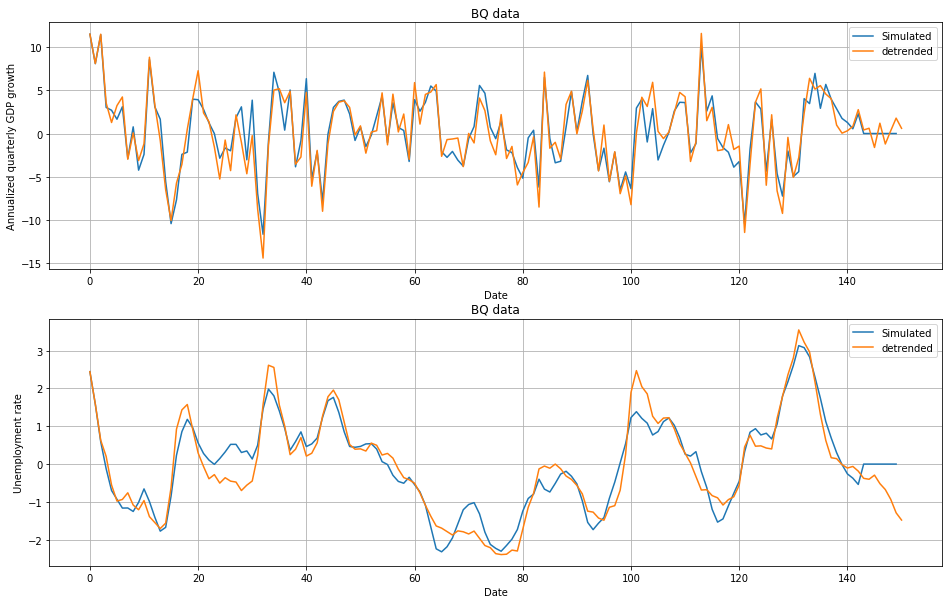

In [28]:
# Plot original data & simulated data
plt.figure(figsize=(16,10))

plt.subplot(211)
plt.plot(X_sim_D[0,:],label='Simulated')
plt.plot(np.array(df['dys'][7:]),label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Annualized quarterly GDP growth')
plt.title('BQ data')
plt.grid()

plt.subplot(212)
plt.plot(X_sim_D[1,:],label='Simulated')
plt.plot(np.array(df['urates'][7:]),label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Unemployment rate')
plt.title('BQ data')
plt.grid()

plt.show()



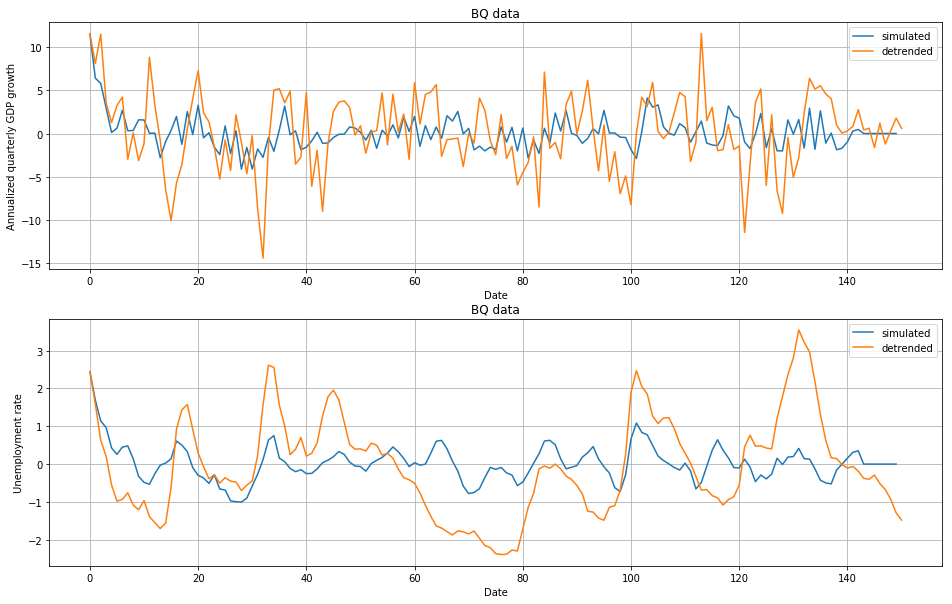

In [29]:
# Plot original data & simulated data
plt.figure(figsize=(16,10))

plt.subplot(211)
plt.plot(X_sim_S[0,:],label='simulated')
plt.plot(np.array(df['dys'][7:]),label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Annualized quarterly GDP growth')
plt.title('BQ data')
plt.grid()

plt.subplot(212)
plt.plot(X_sim_S[1,:],label='simulated')
plt.plot(np.array(df['urates'][7:]),label='detrended')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Unemployment rate')
plt.title('BQ data')
plt.grid()

plt.show()